Using TensorFlow backend.


(50000, 28, 28) (50000,)


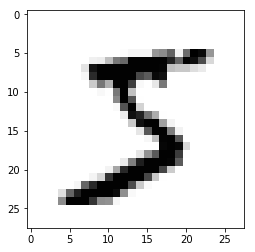

In [1]:
from preprocessed_mnist import load_dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(X_train[0], cmap="Greys");

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import ops
import matplotlib.pyplot as plt

In [3]:
# Get size for training, development (validation), test sets
print(X_train.shape)
m = X_train.shape[0]  # num of training images
n = X_train.shape[1] * X_train.shape[1]  # num of features in 1 image
c = 10 # output has 10 classes
print('m =', m, 'n = ', n)

(50000, 28, 28)
m = 50000 n =  784


In [4]:
# Flatten traingin and test images
def flattenRawData(rawData):
    return rawData.reshape((rawData.shape[0], -1))

X_train_flat = flattenRawData(X_train)
X_val_flat = flattenRawData(X_val)
X_test_flat =flattenRawData(X_test)

# The grayscale images do not require normalize

In [5]:
# Testing bolck 
print('X_train_flat.shape = ', X_train_flat.shape)
print('X_val_flat.shape = ', X_val_flat.shape)
print('X_test_flat.shape = ', X_test_flat.shape)

X_train_flat.shape =  (50000, 784)
X_val_flat.shape =  (10000, 784)
X_test_flat.shape =  (10000, 784)


In [6]:
# Using one hot encoding to generate a m(# of samples) x c(# of classes) matrix
# eg: when c = 3, [[0],[1],[2]] becomes [[1,0,0],[0,1,0],[0,0,1]]
def oneHotMatrix(y, C):
    C = tf.constant(C)
    oneHotMat = tf.one_hot(y, C, axis=1)
    sess = tf.Session()
    one_hot = sess.run(oneHotMat)
    sess.close()
    return np.squeeze(one_hot)

In [7]:
# Testing bolck 
y_train_hot = oneHotMatrix(y_train, c)
y_val_hot = oneHotMatrix(y_val, c)
y_test_hot = oneHotMatrix(y_test, c)
print('y_train_hot.shape = ', y_train_hot.shape)
print('y_train[5] = ', y_train[5])
print('y_train_hot[5,:] = ', str(y_train_hot[5,:]))

y_train_hot.shape =  (50000, 10)
y_train[5] =  2
y_train_hot[5,:] =  [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]


In [8]:
# create Tensors: initializing parameters and creating placeholders
def createPlaceHolders(n, c):
    X = tf.placeholder(tf.float32, shape=(None, n))
    Y = tf.placeholder(tf.float32, shape=(None, c))
    return X, Y

In [9]:
# Testing bolck 
X, Y = createPlaceHolders(n, c)
print ('X = ' + str(X))
print ('Y = ' + str(Y))

X = Tensor("Placeholder:0", shape=(?, 784), dtype=float32)
Y = Tensor("Placeholder_1:0", shape=(?, 10), dtype=float32)


In [10]:
# Initialize 2 hidden layers
def initParameters(n, n_h1, n_h2, c):
    tf.set_random_seed(1)
    W1 = tf.get_variable('W1', [n, n_h1], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable('b1', [1, n_h1], initializer= tf.zeros_initializer())
    W2 = tf.get_variable('W2', [n_h1, n_h2], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable('b2', [1, n_h2], initializer= tf.zeros_initializer())
    W3 = tf.get_variable('W3', [n_h2, c], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable('b3', [1, c], initializer= tf.zeros_initializer())
    return {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}

In [11]:
# Testing bolck 
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initParameters(n, 64, 32, c)
    print('W1 = ' + str(parameters['W1']))
    print('b1 = ' + str(parameters['b1']))
    print('W2 = ' + str(parameters['W2']))
    print('b2 = ' + str(parameters['b2']))
    print('W3 = ' + str(parameters['W3']))
    print('b3 = ' + str(parameters['b3']))

W1 = <tf.Variable 'W1:0' shape=(784, 64) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(1, 64) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(64, 32) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(1, 32) dtype=float32_ref>
W3 = <tf.Variable 'W3:0' shape=(32, 10) dtype=float32_ref>
b3 = <tf.Variable 'b3:0' shape=(1, 10) dtype=float32_ref>


In [12]:
# Activation function can be sigmoid or ReLu
def forwardProp(X, parameters, method = 'relu'):
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(X, W1), b1)
    if method == 'relu':
        A1 = tf.nn.relu(Z1)
    else:
        A1 = tf.nn.sigmoid(Z1)
    Z2 = tf.add(tf.matmul(A1, W2), b2)
    if method == 'relu':
        A2 = tf.nn.relu(Z2)
    else:
        A2 = tf.nn.sigmoid(Z2)
    Z3 = tf.add(tf.matmul(A2, W3), b3)
    return Z3

In [13]:
def computeCost(Z, Y):
#     print('Z.shape=', Z.shape)
#     print('Y.shape=', Y.shape)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z, labels=Y))
    return cost

In [14]:
# Testing bolck 
tf.reset_default_graph()
with tf.Session() as sess:
    X, Y = createPlaceHolders(n, c)
    parameters = initParameters(n, 64, 32, c)
    Z = forwardProp(X, parameters)
    cost = computeCost(Z, Y)
    print('cost = ', cost)

cost =  Tensor("Mean:0", shape=(), dtype=float32)


In [15]:
# Generate mini batches
def genMiniBatch(X, Y, mini_batch_size = 64, seed = 0):
    # TODO: 1 shuffle, 2 partition, 3 handle the leftover
    m = X.shape[0]    # # of training samples
    mini_batches = []
    np.random.seed(seed)    # reset RNG
    
    # shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation, :] # ??? .reshape((m, Y.shape[1])) 
    
    # partition
    num_full_batches = int(np.floor(m/mini_batch_size))
    for i in range(0, num_full_batches):
        mini_batch_X = shuffled_X[i*mini_batch_size : i*mini_batch_size+mini_batch_size, :]
        mini_batch_Y = shuffled_Y[i*mini_batch_size : i*mini_batch_size+mini_batch_size, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # attach the leftover at the ned
    if m % mini_batch_size !=0:
        mini_batch_X = shuffled_X[num_full_batches * mini_batch_size : m, :]
        mini_batch_Y = shuffled_Y[num_full_batches * mini_batch_size : m, :]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [16]:
def drawPlot(data, x_label, y_label, title):
    plt.plot(np.squeeze(data))
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.title(title)
    plt.show()

In [61]:
def model(X_train, Y_train, X_dev, Y_dev, 
          n_hidden1=64, n_hidden2=32, learning_rate=0.01, decay_rate=0.96, num_epochs=500, minibatch_size=128):
    ops.reset_default_graph()
    tf.set_random_seed(1)
    (m, n) = X_train.shape
    c = Y_train.shape[1]
    print('m = ', m, 'n = ', n, 'c = ', c)
    costs = []
    learning_rates = []
    seed = 1
    num_minibatches = int(m/minibatch_size)
    
    # initialization
    X, Y = createPlaceHolders(n, c)
    parameters = initParameters(n, n_hidden1, n_hidden2, c)
    
    # forward propagation
    Z = forwardProp(X, parameters)
    # update cost
    cost = computeCost(Z, Y)
    
    # ues learning rate decay
    global_step = tf.Variable(0, trainable=False)
    adapt_learning_rate = tf.train.natural_exp_decay(learning_rate, global_step, num_minibatches*20, decay_rate)
    
    # back propagation
    optimizer = tf.train.AdamOptimizer(adapt_learning_rate).minimize(cost, global_step=global_step)    
        
    init = tf.global_variables_initializer()
    with tf.Session() as sess:
        sess.run(init)
        
        for epoch in range(num_epochs):
            epoch_cost = 0.0
            seed += 1
            minibatches = genMiniBatch(X_train, Y_train, minibatch_size, seed)
            
            for minibatch in minibatches:
                (mini_X, mini_Y) = minibatch
                _ , mini_cost = sess.run([optimizer, cost], feed_dict={X: mini_X, Y: mini_Y})
                epoch_cost += mini_cost / num_minibatches
                
            # print accuracy for dev set
            if epoch % 20 == 0:
                print ("Cost after epoch %i: %f, Learning_rate = %f" % (epoch, epoch_cost, adapt_learning_rate.eval()))
            costs.append(epoch_cost)
            learning_rates.append(adapt_learning_rate.eval())
            
            if epoch_cost < 1.0e-6:
                break
        
        # plot cost
        drawPlot(costs, 'iterations', 'cost', 'Cost vs. Iteration')
        
        # plot learning rate
        drawPlot(learning_rates, 'iterations', 'Learning rate', 'Larning rate vs. Iteration')
        
        correct_prediction = tf.equal(tf.argmax(Z, axis=1), tf.argmax(Y, axis=1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_dev, Y: Y_dev}))
        
        parameters = sess.run(parameters)
        return parameters

In [62]:
%%time
tf.reset_default_graph()
parameters = model(X_train_flat, y_train_hot, X_val_flat, y_val_hot, n_hidden1=128, n_hidden2=64, num_epochs=300)

m =  50000 n =  784 c =  10
Cost after epoch 0: 0.246226, Learning_rate = 0.009530
Cost after epoch 20: 0.007543, Learning_rate = 0.003640
Cost after epoch 40: 0.000007, Learning_rate = 0.001390
Cost after epoch 60: 0.000001, Learning_rate = 0.000531
Cost after epoch 80: 0.000000, Learning_rate = 0.000203
Cost after epoch 100: 0.000000, Learning_rate = 0.000077
Cost after epoch 120: 0.000000, Learning_rate = 0.000030
Cost after epoch 140: 0.000000, Learning_rate = 0.000011
Cost after epoch 160: 0.000000, Learning_rate = 0.000004
Cost after epoch 180: 0.000000, Learning_rate = 0.000002


KeyboardInterrupt: 

In [63]:
# show overall performance
XT, YT = createPlaceHolders(n, c)
Z = forwardProp(XT, parameters)
correct_prediction = tf.cast(tf.equal(tf.argmax(Z, axis=1), tf.argmax(YT, axis=1)), tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

with tf.Session() as sess:
    acc = sess.run(accuracy, feed_dict = {XT: X_train_flat, YT: y_train_hot})
    print ("Train Accuracy:", acc)
    acc = sess.run(accuracy, feed_dict = {XT: X_val_flat, YT: y_val_hot})
    print ("Dev Accuracy:", acc)
    acc = sess.run(accuracy, feed_dict = {XT: X_test_flat, YT: y_test_hot})
    print ("Test Accuracy:", acc)

Train Accuracy: 1.0
Dev Accuracy: 0.9793
Test Accuracy: 0.9803


In [ ]:
# pass raw image and raw label for prediction
def predictRawImage(img, parameters, y):
    x = img.reshape((1, img.shape[0]* img.shape[1]))
    XT, YT = createPlaceHolders(n, c)
    y_hat = forwardProp(XT, parameters)
    predict = tf.argmax(y_hat, axis=1)

    with tf.Session() as sess:
            y_predict = sess.run(predict, feed_dict={XT: x})
            print("The prediction is %i, the label is %s" % (np.squeeze(y_predict), str(y)))

    %matplotlib inline
    plt.imshow(img, cmap="Greys");


In [ ]:
# Testing block
index = 666
predictRawImage(X_test[index, :], parameters, y_test[index])
